In [1]:
#   ======================   #
#%% CALCULATION PARAMETERS %%#
#   ======================   #   

orbital = "Eg"
norbitals = 2

# construction and diagonalization in a single step
onestep = true
# use precomputed spin-CG coefficients
spinarray = true
# parallel computation
distributed = parallel = false
# parallel method: distfor or async
method = "distfor"
# discretization ("standard" or "co2005")
discretization = "co2005"

# clean system or with impurity added
calculation = "IMP"

# twisting parameter
z = 0.0

# numerical parameters
L = 10.0
betabar = 1.0

# cutoff
cutoff_type = "multiplet" 
cutoff_magnitude = 100
minmult = 0

# command-line input
u_11_r = 0.7
u_h_r  = 0.5
gam_r  = 0.3
if length(ARGS)>0
    # clean/imp
    calculation = "IMP"
    if ARGS[1]=="CLEAN" 
        calculation = "CLEAN"
    end
    # twisting parameter
    if length(ARGS)>1
        z = parse(Float64,ARGS[2])
    end
    # relative parameters
    if length(ARGS)>2
        u_11_r = parse(Float64,ARGS[3])
        u_h_r  = parse(Float64,ARGS[4]) 
        gam_r  = parse(Float64,ARGS[5])
    end
end

## standard parameters 
#U   = 0.2
#U12 = 0.8*U
#J   = 0.5*( U - U12 )
#u_eg =  U - J
#u_a1 =  U + J
#u_a2 =  U12 - J 

# one-body coupling parameters
eps  = -0.1
gam = gam_r*abs(eps) # gam = √2Δ/π 
# coulomb coupling parameters
u_11 = u_11_r*abs(2*eps)
u_12 = u_11 
u_h  = u_h_r*( 2*u_12 )
u_eg = u_11
u_a1 = u_12 + u_h/2.0
u_a2 = u_12 - u_h/2.0

iterations = 10

max_spin2 = 8

distworkers = 6

println( "====================" )
println( "SETUP AND PARAMETERS" )
println( "====================" )
@show calculation
@show distributed 
distributed && @show distworkers
@show method
@show discretization
@show z
@show eps   
@show u_eg 
@show u_a1 
@show u_a2 
@show gam  
@show L
@show betabar
@show cutoff_type
@show cutoff_magnitude
@show iterations
@show max_spin2
println()


SETUP AND PARAMETERS
calculation = "IMP"
distributed = false
method = "distfor"
discretization = "co2005"
z = 0.0
eps = -0.1
u_eg = 0.13999999999999999
u_a1 = 0.20999999999999996
u_a2 = 0.06999999999999999
gam = 0.03
L = 10.0
betabar = 1.0
cutoff_type = "multiplet"
cutoff_magnitude = 100
iterations = 10
max_spin2 = 8



In [2]:
#   =======================   #
#%% MODULES AND DISTRIBUTED %%#
#   =======================   #

using DelimitedFiles
using ProfileVega
using Profile

include( "modules/symbols.jl" )
include( "modules/numericals.jl" )
include( "modules/compoundoperators.jl" )
include( "modules/shell.jl" )
include( "modules/thermo.jl" )
include( "modules/discretization.jl" )

if parallel 

    using Distributed 

    # kill current processes
    for i in workers()
        t = rmprocs(i, waitfor=0)
        wait(t)
    end

    # add requested workers
    if distworkers ≥ nprocs()
        addprocs(distworkers)
    else 
        println( "more workers than processors!" )
    end

    println( "DISTRIBUTED CALCULATION WITH $(nworkers()) WORKERS" )

    @everywhere begin 
        using ProgressMeter
        using PartialWaveFunctions
        using StaticArrays
        include( "modules/symmetry.jl" )
        include( "modules/diagonalization.jl" )
    end

else 

    println( "SERIAL CALCULATION" )

    using ProgressMeter
    using PartialWaveFunctions
    using StaticArrays

    include( "modules/symmetry.jl" )
    include( "modules/diagonalization.jl" )

end
println()


SERIAL CALCULATION


In [3]:
#   ======================   #
#%% ORBITAL CLEBSCH-GORDAN %%#
#   ======================   #

CG_PATH = "/home/aitor/Bulegoa/ClebschGordan/Oh/cg_symbolic/"
ASYM_PATH = "/home/aitor/Bulegoa/AntiSymmetricPart/Oh/";

ORBITAL_IRREPS = ( "Eg" , )
oirreps = cg_shortcircuit( CG_PATH , ORBITAL_IRREPS... )
oirreps2indices = Dict( o=>i for (i,o) in enumerate(oirreps) )
oirreps2dimensions = Dict( "Eg" => 2 ,
                           "A1g"=> 1 ,
                           "A2g"=> 1 )
oindex2dimensions = collect( oirreps2dimensions[I] for I in oirreps )
println( "ORBITAL IRREPS FOR THE PROBLEM" )
println( oirreps )
println()

cg_o_full = get_cg_o_fulldict( oirreps , CG_PATH )
cg_o_fullmatint = get_cg_o_fullmatint( cg_o_full , oirreps )
#println( "CLEBSCH-GORDAN MATRIX" )
#print_dict( cg_o_fullmatint )
#println()


#   ===================   #
#%% SPIN CLEBSCH-GORDAN %%#
#   ===================   #
cg_s_fullmatint = get_cg_s_fullmatint( max_spin2 );


#   ==================================   #
#&& ONE-SHELL SYMSTATES AND MULTIPLETS &&#
#   ==================================   #

#   ----------------------- #
#%% basis and hilbert space #
#   ----------------------- #
hilbert_0 = HilbertSpace( Eg_states(0) )
basis_0 = CanonicalBasis( hilbert_0 )
println( "BASIS FOR ATOMIC SHELL" )
println( basis_0 )


#   ------------------------ #
#%% symstates and multiplets #
#   ------------------------ #
hiztegia = Dict( 
    "e" => "Eg",
    "u" => 0.5,
    "d" =>-0.5
)

symstates_0_nor = oneirrep_symstates( hilbert_0 , 
                                      hiztegia , 
                                      "A1g" , 
                                      "$(ASYM_PATH)$(orbital)_julia/" )
symstates_0 = Dict( (q[1:5]...,1)=>s for (q,s) in symstates_0_nor )
println( "SYMSTATES" )
for q in sort(collect(keys(symstates_0)),by=x->x[1])
    @show q 
    println( symstates_0[q] )
    println()
end
println()

multiplets_0 = get_multiplets( symstates_0 )
println( "ATOMIC MULTIPLETS" )
for m in multiplets_0 
    @show m 
end
println()


#   ---------   #
#%% operators %%#
#   ---------   #
epsilon_symparams = Dict( 
    "Eg" => eps
)
epsilon = epsilon_sym( symstates_0 , epsilon_symparams ; verbose=false )
#println( "EPSILON OPERATOR" )
#print_diagonals( epsilon )

u_symparams = Dict( 
    ("Eg", 0) => [u_eg][:,:],
    ("A1g",0) => [u_a1][:,:],
    ("A2g",1) => [u_a2][:,:]
)
coulomb = u_sym( symstates_0 , u_symparams ; verbose=false )
println( "COULOMB OPERATOR" )
print_diagonals( coulomb )
println()


#   ---------------------------   #
#%% atomic hamiltonian (scaled) %%#
#   ---------------------------   #
H = epsilon + coulomb 
# α = ϵ_0^z (scaling factor)
if discretization=="standard"
    global α = 0.5 * L^z * (1+L^-1)
elseif discretization=="co2005"
    global α = compute_ebar0_z(z,L;discretization=discretization)
end
H.matrix ./= α
gam /= α
#gam = sqrt(2.0*gam/pi) / α # for later
#println( "H OPERATOR" )
#print_diagonals( H )
#println()




ORBITAL IRREPS FOR THE PROBLEM
["A2g", "A1g", "Eg"]

BASIS FOR ATOMIC SHELL
1: |)
2: | 0 e 1 u )
3: | 0 e 1 d )
4: | 0 e 2 u )
5: | 0 e 2 d )
6: | 0 e 1 u , 0 e 1 d )
7: | 0 e 1 u , 0 e 2 u )
8: | 0 e 1 u , 0 e 2 d )
9: | 0 e 1 d , 0 e 2 u )
10: | 0 e 1 d , 0 e 2 d )
11: | 0 e 2 u , 0 e 2 d )
12: | 0 e 1 u , 0 e 1 d , 0 e 2 u )
13: | 0 e 1 u , 0 e 1 d , 0 e 2 d )
14: | 0 e 1 u , 0 e 2 u , 0 e 2 d )
15: | 0 e 1 d , 0 e 2 u , 0 e 2 d )
16: | 0 e 1 u , 0 e 1 d , 0 e 2 u , 0 e 2 d )
SYMSTATES
q = (0, "A1g", 0, 1, 0, 1)
(1.0 + 0.0im) |)

q = (1, "Eg", 0.5, 1, 0.5, 1)
(1.0 + 0.0im) | 0 e 1 u )

q = (1, "Eg", 0.5, 1, -0.5, 1)
(1.0 + 0.0im) | 0 e 1 d )

q = (1, "Eg", 0.5, 2, -0.5, 1)
(1.0 + 0.0im) | 0 e 2 d )

q = (1, "Eg", 0.5, 2, 0.5, 1)
(1.0 + 0.0im) | 0 e 2 u )

q = (2, "Eg", 0.0, 2, 0.0, 1)
(1.0 - 0.0im) | 0 e 1 u , 0 e 1 d )

q = (2, "A1g", 0.0, 1, 0.0, 1)
(0.7071067811865474 + 0.0im) | 0 e 1 u , 0 e 2 d ) + (-0.7071067811865477 + 0.0im) | 0 e 1 d , 0 e 2 u )

q = (2, "A2g", 1.0, 1, 0.

0.07675283650988768941579337347277812135163245388394554908083020667685353962518017

In [4]:
#   ================================================   #
#&& NUMERICAL ADDITION OF INNERMOST CONDUCTION SHELL &&#
#   ================================================   #

#   -----   #
#%% irreu %%#
#   -----   #
# imp
if calculation=="IMP"
    irreps_0 = get_irreps( symstates_0 )
    irrEU_imp = symdiag( irreps_0 , symstates_0 , H )
    println( "irrEU for IMP" )
    print_dict( irrEU_imp )
    println()
# clean
elseif calculation=="CLEAN"
    irrEU_clean = get_irrEU_clean( "A1g" )
    println( "irrEU for CLEAN" )
    print_dict( irrEU_clean )
    println()
end


#   ---------------   #
#%% combinations u' %%#
#   ---------------   #
combinations_uprima = 
    Dict{ Tuple{Int64,Int64,Int64,Int64} , NTuple{2,Tuple{Int64,Int64,Int64,Int64}} }()
m_vac = (0,oirreps2indices["A1g"],0,1)
#print( "COMBINATIONS U' " )
if calculation=="IMP"
    #println( "for IMP" )
    for m_mu in multiplets_0
        mint_mu = convert_to_int( m_mu , oirreps2indices )
        push!( combinations_uprima , mint_mu=>(mint_mu,m_vac) )
    end 
elseif calculation=="CLEAN" 
    #println( "for CLEAN" )
    push!( combinations_uprima , m_vac=>(m_vac,m_vac) )
end

irreps_uprima = Set( k[1:3] for k in keys(combinations_uprima) )
combinations_uprima = 
        Dict{ NTuple{3,Int64} , Vector{NTuple{3,NTuple{4,Int64}}} }(
            G => NTuple{3,NTuple{4,Int64}}[
                (m_u,m_mu,m_i)
                for (m_u,(m_mu,m_i)) in combinations_uprima 
                if m_u[1:3]==G
                ]
            for G in irreps_uprima
        ) 
println( "COMBINATIONS U' FOR N=0" )
for (G,combs) in combinations_uprima
    println( "$G => $combs" )
end
println()

#   ----------------------   #
#%% pseudo-CG coefficients %%#
#   ----------------------   #
pcg = get_pseudoCG( symstates_0 , basis_0 , hiztegia , oirreps2indices )
#println( "PCG" )
#print_dict( pcg ) 
#println()

# PCG matrix in int format
irrmult_0 = get_irreps( multiplets_0 ; multiplicity=true )
pcgmat = get_pseudoCG_mat( pcg , irrmult_0 , oindex2dimensions );

#   -------------------   #
#%% shell cops and qq_a %%#
#   -------------------   #
shell_cops = shell_coperators( basis_0 , hiztegia )
qq_a = collect( convert_to_int(q_a,oirreps2indices) 
                for q_a in keys(shell_cops) )
println( "ONE-PARTICLE HOPPERS" )
@show qq_a;
println()

#   -----------------   #
#%% hopping parameter %%#
#   -----------------   #
hop = Dict( 
    (oirreps2indices["Eg"],1) => ComplexF64(gam) 
)
println( "ATOM-SHELL HOPPING PARAMETER" )
@show hop
println()

#   --------------------------   #
#%% block and shell multiplets %%#
#   --------------------------   #
if calculation=="IMP"
    symstates_block = symstates_0 
    multiplets_block = get_multiplets( symstates_block )
    global irrEU = Dict( (convert_to_int(G,oirreps2indices),(E,U))
                   for (G,(E,U)) in irrEU_imp )
    println( "irrEU before adding first shell (to IMP)" )
    for (G,(E,U)) in irrEU 
        @show G, E
    end
    println()
elseif calculation=="CLEAN"
    multiplets_block = Set([(0,"A1g",0.0,1)])
    global irrEU = Dict( (convert_to_int(G,oirreps2indices),(E,U))
                   for (G,(E,U)) in irrEU_clean )
    println( "irrEU before adding first shell (to CLEAN)" )
end 
symstates_shell  = symstates_0 
multiplets_shell = multiplets_0

multiplets_block = Set( convert_to_int(m,oirreps2indices) 
                        for m in multiplets_block )
multiplets_shell = Set( convert_to_int(m,oirreps2indices)
                        for m in multiplets_shell )

#   ------------------------   #
#%% impurity quantum numbers %%#
#   ------------------------   #
function ordered_multiplets( mults ) 
    max_N = maximum(k[1] for k in mults) 
    omults = []
    for N in 0:max_N 
        for mult in mults
            mult[1]==N || continue
            push!(omults,mult)
        end
    end
    return omults
end

println("IMPURITY MULTIPLET SPACE")
omults = ordered_multiplets(multiplets_block)
mult2index = Dict( m=>i for (i,m) in 
                   enumerate(omults))
mm_i = Dict( 
            m=>[(i==mult2index[m] ? 1.0 : 0.0)
                for i in 1:length(multiplets_block)] 
                for m in omults
           )
@show mm_i 
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )


#   ---------------------------------------   #
#%% matrix construction and diagonalization %%#
#   ---------------------------------------   #
if distributed && onestep
    @time begin
    global (irrEU,combinations_uprima) = matdiag_distributed( 
                multiplets_block , 
                multiplets_shell ,
                irrEU , 
                hop , 
                cg_o_fullmatint , 
                cg_s_fullmatint ,
                pcg , 
                pcgmat, 
                qq_a , 
                combinations_uprima , 
                oindex2dimensions ;
                verbose=false );
    end
else
    @time begin
    global (irrEU,combinations_uprima) = matdiag_serial( 
                multiplets_block , 
                multiplets_shell ,
                irrEU , 
                hop , 
                cg_o_fullmatint , 
                cg_s_fullmatint ,
                pcg , 
                pcgmat, 
                qq_a , 
                combinations_uprima , 
                oindex2dimensions ;
                verbose=false );
    end
end
minE = minimum([e for (E,U) in values(irrEU) for e in E])
irrEU = Dict( G=>(E.-minE,U) for (G,(E,U)) in irrEU )
energies = sort([e for (E,U) in values(irrEU) for e in E])

mm_i = imp_mults( irrEU ,
                  oindex2dimensions ,
                  combinations_uprima ,
                  mm_i )
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )

irrEU for IMP
(2, "A1g", 0.0)
([0.025584278836629094], ComplexF64[1.0 + 0.0im])

(3, "Eg", 0.5)
([0.12792139418314613], ComplexF64[1.0 + 0.0im])

(1, "Eg", 0.5)
([-0.2558427883662923], ComplexF64[1.0 + 0.0im])

(2, "A2g", 1.0)
([-0.33259562487618], ComplexF64[1.0 + 0.0im])

(0, "A1g", 0.0)
([0.0], ComplexF64[1.0 + 0.0im])

(4, "A1g", 0.0)
([0.7675283650988762], ComplexF64[1.0 + 0.0im])

(2, "Eg", 0.0)
([-0.15350567301977544], ComplexF64[1.0 + 0.0im])


COMBINATIONS U' FOR N=0
(3, 3, 1) => [((3, 3, 1, 1), (3, 3, 1, 1), (0, 2, 0, 1))]
(1, 3, 1) => [((1, 3, 1, 1), (1, 3, 1, 1), (0, 2, 0, 1))]
(0, 2, 0) => [((0, 2, 0, 1), (0, 2, 0, 1), (0, 2, 0, 1))]
(4, 2, 0) => [((4, 2, 0, 1), (4, 2, 0, 1), (0, 2, 0, 1))]
(2, 2, 0) => [((2, 2, 0, 1), (2, 2, 0, 1), (0, 2, 0, 1))]
(2, 3, 0) => [((2, 3, 0, 1), (2, 3, 0, 1), (0, 2, 0, 1))]
(2, 1, 2) => [((2, 1, 2, 1), (2, 1, 2, 1), (0, 2, 0, 1))]

ONE-PARTICLE HOPPERS
qq_a = [(1, 3, 1, 2, -1, 1), (1, 3, 1, 1, 1, 1), (1, 3, 1, 1, -1, 1), (1, 3, 1, 2, 1, 1)]



7-element Vector{Float64}:
 0.056721178365880344
 0.29282525690692757
 0.1321728890749299
 0.2370669600953556
 0.05526981589738377
 0.19959129351027222
 0.02635260614925036

In [5]:
#   =============   #
#%% NRG PROCEDURE %%# 
#   =============   #
hopchannels = collect(keys( hop ))
@profile global nrg = NRG( iterations , 
           cutoff_type , 
           cutoff_magnitude , 
           L , 
           hopchannels , 
           irrEU , 
           cg_o_fullmatint , 
           pcg ,
           pcgmat ,
           qq_a ,
           combinations_uprima ,
           betabar ,
           oindex2dimensions ,
           mm_i ;
           spinarray=spinarray ,
           cg_s_fullmatint=cg_s_fullmatint ,
           distributed=parallel ,
           minmult=minmult ,
           discretization=discretization ,
           z=z )
println()

NRG PROCEDURE

ITERATION n=2
Applying cutoff to obtain block multiplets...   0.000031 seconds (160 allocations: 34.273 KiB)
85 multiplets kept (171 states), 0 multiplets discarded
proportion: 100.0%. max energy: 1.3056868838124673. max spin: 4
Renormalizing eigenvalues...
shell hopping = 0.9491579967016569872598870061782055794435902459145845959773787545566570511461326
Diagonalizing Hamiltonian...
(ppp.time, ppp.bytes * 10 ^ -6, ppp.gctime) = (0.153729691, 38.44004800000001, 0.015382751)
m_imp = [0.04069000713114803, 0.351329453024183, 0.12797367385679076, 0.33148231672751377, 0.03674186437752657, 0.10799513313363411, 0.0037875517492045228]
THERMODYNAMICS
t = 0.55
ρ = 119.35306302447712
entr = 4.782086016674011
mag = 0.7337890260763341
N = 0.4505042649579338
en = 2.5057289551121698

ITERATION n=3
Applying cutoff to obtain block multiplets...   0.025563 seconds (45.56 k allocations: 2.877 MiB, 96.14% compilation time)
103 multiplets kept (240 states), 1048 multiplets discarded
proportion

In [6]:
#   ===========   #
#%% PERFORMANCE %%#
#   ===========   #

println( "===========" )
println( "PERFORMANCE" )
println( "===========" )
print_performance_onestep(nrg)
println()

PERFORMANCE
TIME (s)
minimum time: 0.153729691
maximum time: 1.205841444
mean time:    0.7820765545555557

minimum gigabytes: 0.038440048
maximum gigabytes: 0.07953872
mean gigabytes:    0.056054384222222225

minimum gc time: 0.004669265
maximum gc time: 0.015382751
mean gc time:    0.007841963888888888



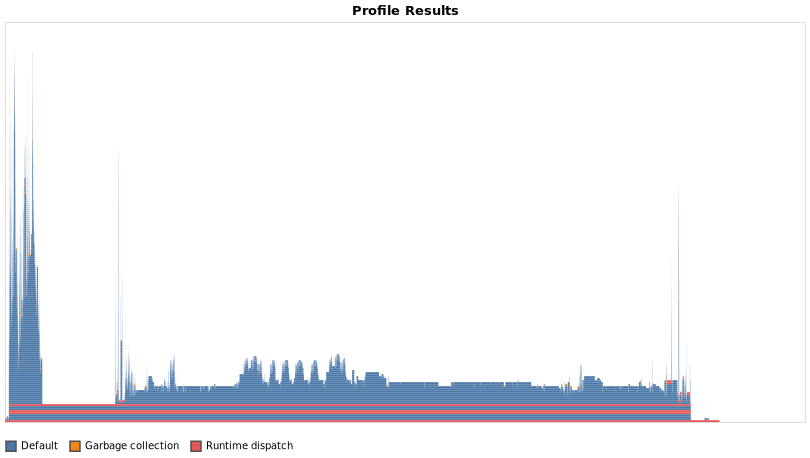

In [7]:
ProfileVega.view()